# Find candidates with nearby stars of similar $K_p$

### Outline
* Set separation limits to search within, i.e.: look for stars with a similar magnitude pair separated by 2 to 5 arcminutes

* Set threshold for how similar in $K_p$ targets must be

* Toss any pairs when one component has a nearby bright star (contaminant) within some radius

* Save outputs to text file `candidates_with_neighbors.txt`

In [60]:
%matplotlib inline
from astropy.io import ascii
from astropy.table import Table, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
import matplotlib.pyplot as plt

############################################################
# Settings #################################################

path = 'candidates_with_neighbors.txt' # output file name
recalculate = True # Calculate or use precalculated table

# Settings for the K2-two pairs
pair_separation_limits = [2, 5] # Inner and outer angle in arcmin
pair_delta_Kp = 1. # Maximum difference in Kepler magnitude

# Precautions to avoid nearby contaminant stars
contaminant_separation_limit = 0.5 # [arcmin] toss pairs with contaminants this close

############################################################

if recalculate:
    on_chip = ascii.read('on_chip.csv')
    on_chip['ra'].unit = u.degree
    on_chip['dec'].unit = u.degree

    has_neighbor = np.zeros(len(on_chip['ra'])).astype(bool)
    N_neighbors = np.zeros(len(on_chip['ra']))
    
    # Store vectorized coordinates for all stars
    allstarsonchip = SkyCoord(on_chip['ra'], on_chip['dec'])

    for i, star in enumerate(on_chip):
        ra, dec, Kp = list(star)
        
        # Calculate separation, mag difference between all stars
        candidate = SkyCoord(ra, dec, unit=(u.degree, u.degree))
        separations = candidate.separation(allstarsonchip).arcmin
        deltaKp = np.abs(on_chip['Kp'] - Kp)
        good_neighbors = ((separations > pair_separation_limits[0]) * 
                          (separations < pair_separation_limits[1]) *
                          (deltaKp < pair_delta_Kp))
        
        # If any stars fall within separation+mag thresholds,                    
        # check if either of the stars in the candidate pair has
        # a bright star nearby that could fall into your slit
        if np.sum(good_neighbors) > 0:
            # State Farm is there.
            N_neighbors[i] = np.sum(good_neighbors)
            
            no_contaminants = np.ones(np.sum(good_neighbors)).astype(bool)
            for j, star in enumerate(on_chip[good_neighbors]):
                ra, dec, Kp = list(star)
                candidate_with_neighbor = SkyCoord(ra, dec, unit=(u.degree, u.degree))
                separations = candidate_with_neighbor.separation(allstarsonchip).arcmin
                any_contaminants = np.sum(separations < contaminant_separation_limit)
                
                if any_contaminants > 1:
                    # There will always be at least one "contaminant" by this
                    # definition (the target star), so trigger on >1
                    no_contaminants[j] = False
                    print("Excluding star at ({0},{1}) for nearby contaminant".format(ra,dec))
            
            # If there are no nearby contaminants, mark this star as a valid
            # candidate with a neighbor
            if no_contaminants.all():
                has_neighbor[i] = True
    
    candidates_with_neighbors = on_chip[has_neighbor]
    candidates_with_neighbors.sort('Kp')
    ascii.write(candidates_with_neighbors, path)
else:
    candidates_with_neighbors = ascii.read(path)

Excluding star at (14.771578,5.381362) for nearby contaminant
Excluding star at (14.772829,5.381958) for nearby contaminant
Excluding star at (19.021868,2.996939) for nearby contaminant


### Plot K2-twos

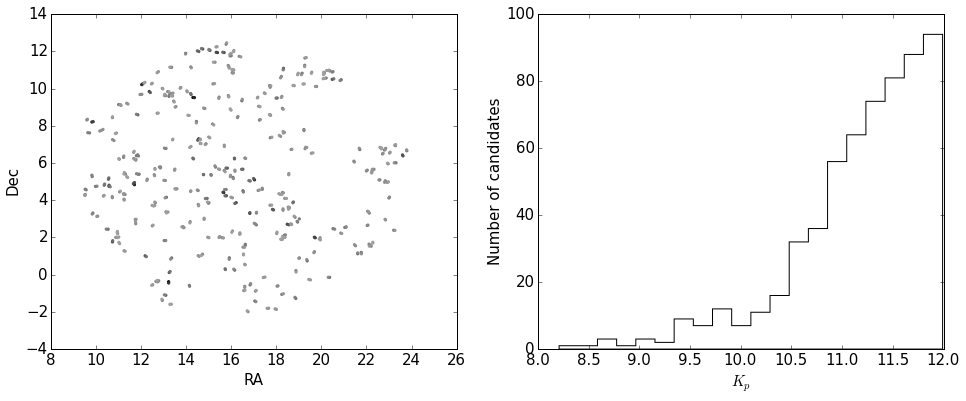

In [61]:
def plotfield(tbl):
    # Make colormap correspond to Kepler mag
    colorscale = 1. / tbl['Kp']
    colorscale = 2*colorscale/colorscale.max() - 1
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    cm = plt.cm.binary
    ax[0].scatter(tbl['ra'], tbl['dec'], marker='.', 
                  color=cm(colorscale))
    ax[0].set_xlabel('RA')
    ax[0].set_ylabel('Dec')

    ax[1].hist(tbl['Kp'], 20, histtype='stepfilled',
               color='w')
    ax[1].set_ylabel('Number of candidates')
    ax[1].set_xlabel('$K_p$')
    plt.show()

plotfield(candidates_with_neighbors)

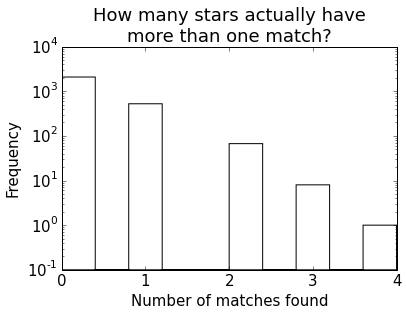

Number of stars with 0 matching comparisons: 2083
Number of stars with 1 matching comparisons: 524
Number of stars with 2 matching comparisons: 67
Number of stars with 3 matching comparisons: 8
Number of stars with 4 matching comparisons: 1


In [63]:
fig, ax = plt.subplots()
ax.hist(N_neighbors, histtype='stepfilled', log=True, 
        color='w')
ax.set_xticks(range(5))
ax.set_xlabel('Number of matches found')
ax.set_ylabel('Frequency')
ax.set_title('How many stars actually have\nmore than one match?')
plt.show()

for i in range(5):
    print("Number of stars with {0} matching comparisons: {1}".format(i, 
          list(N_neighbors).count(i)))